# Safety

## Decide if $(d, cap)$ is safe in a given state
Given a state $s$ we want to decide whether there exists a strategy $\sigma$ such that all runs that follow $\sigma$ and that start with the initial resource value $d$ in $s$ will be safe in a system with capacity $cap$. By safe here we mean that the resource will never be depleted.

### MinInitCons
The function $\mathrm{MinInitCons}[\mathcal{M}]: S \to \mathbb{N} \cup \{\infty\}$ computes the minimal consumption until a reload state is reached.

In [1]:
%%writefile safety.py
from math import inf
import sys
debug = False
debug_vis = False

def largest_fixpoint(mdp, values, action_value,
                     value_adj=lambda s, v: v,
                     skip_state=lambda x: False):
    """Largest fixpoint on list of values indexed by states.

    The value of a state `s` is a minimum over `action_value(a)`
    among all posible actions `a` of `s`. Values should be
    properly initialized (to ∞ or some other value) before calling.

    Parameters
    ==========
     * mdp      : `consMDP`
     * values   : `list of ints` values for the fixpoint

     * action_value : function that computes a value of an action
                      based on current values in `values`. Takes
                      2 paramers:
        - action    : `ActionData` action of MDP to evaluate
        - values    : `list of ints` current values

     * functions that alter the computation:
       - value_adj : `state × v -> v'` (default `labmda x, v: v`)
                      Change the value `v` for `s` to `v'` in each
                      iteration (based on the candidate value).
                      For example use for `v > capacity -> ∞`
                      Allows to handle various types of states
                      in a different way.

       - skip_state : `state -> Bool` (default `lambda x: False`)
                      If True, stave will be skipped and its value
                      not changed.
    """
    states = len(values)
    act_value = lambda a: action_value(a, values)

    # iterate until a fixpoint is reached
    iterate = True
    c = 0
    while iterate:
        if debug: print(f"it {c}\t:{values}")
        if debug_vis: display(f"Iteration {c}:", mdp.show("Mr"))
        c += 1
        iterate = False

        for s in range(states):
            if skip_state(s):
                continue
            current_v = values[s]
            actions = mdp.actions_for_state(s)
            # candidate_v is the minimum over action values
            candidate_v = min([act_value(a) for a in actions])

            # apply value_adj (capacity, reloads, ...)
            candidate_v = value_adj(s, candidate_v)

            # check for decrease in value
            if candidate_v < current_v:
                values[s] = candidate_v
                iterate = True


class minInitCons:
    """Compute function minInitCons for given consMDP `m`.

    minInitCons_m: S -> N ∪ {∞} returns for given `s` the minimum
    amount `s_m` of resource such that there exists a strategy that
    guarantees reachability of some reload state from s consuming
    at most `s_m`.

    Typical use:
    MI = minInitCons(mdp)
    MI.get_values()
    """

    def __init__(self, mdp, cap = inf):
        # cap has to be defined
        if cap is None:
            cap = inf

        self.mdp         = mdp
        self.states      = mdp.num_states
        self.cap         = cap
        self.values      = None
        self.safe_values = None

        self.is_reload  = lambda x: self.mdp.is_reload(x)

    def action_value(self, a, values, zero_cond = None):
        """
        - action    : `ActionData` action of MDP to evaluate
        - values    : `list of ints` current values
        - zero_cond : `list of Bool` if `True` for `s`, the
                       value of `s` will be trated as 0
        """
        if zero_cond is None:
            zero_cond = self.is_reload
        non_reload_succs = [values[succ] for succ in a.distr.keys()
                   if not zero_cond(succ)]
        a_v = 0 if len(non_reload_succs) == 0 else max(non_reload_succs)
        return a_v + a.cons

    def sufficient_levels(self, removed=None, values=None,
                          init_val=lambda s: inf):
        """Compute the safe_values using the largest-fixpoint method
        based on minInitCons computation with removal of reload states
        that have minInitCons() = ∞ in the previous itertions.

        The first computation computes, in fact, minInitCons (redundantly)

        The worst-case complexity is |R| * minInitCons = |R|*|S|^2

        `removed` : set of reloads - start with the reloads already removed
                    ∅ by default
        `values`  : list used for computation
                    self.safe_values as default
        `init_val`: state -> value - defines the values at the start of each
                    iteration
        """
        if values is None:
            values = self.safe_values

        if removed is None:
            removed = set()

        done = False
        while not done:
            # Compute fixpoint without removed reloads

            # Reset the computation, by default set all values to ∞.
            # `init_val: s -> v
            for s in range(self.states):
                values[s] = init_val(s)

            # Mitigate reload removal
            zero_cond = lambda x: self.is_reload(x) and x not in removed
            rem_action_value = lambda a, v: self.action_value(a, v, zero_cond)

            # Removed reloads are skipped
            skip_cond = lambda x: x in removed # Improve performance only
            # Over capacity values -> ∞
            cap = lambda s, v: inf if v > self.cap else v

            largest_fixpoint(self.mdp, values,
                             rem_action_value,
                             value_adj=cap,
                             skip_state=skip_cond)

            done = True
            # Iterate over reloads and remove unusable ones (∞)
            for s in range(self.states):
                if self.is_reload(s) and values[s] == inf:
                    if s not in removed:
                        removed.add(s)
                        done = False

        # Set reload values to 0
        for s in range(self.states):
                if self.mdp.is_reload(s) and values[s] < self.cap:
                    values[s] = 0

    def safe_reloads_fixpoint(self):
        """Iterate on minInitCons and disable reloads with MI > cap

        Basicaly a least fixpoint that starts with minInitCons. If some
        reload has MI > cap, it is converted to ∞, and we no longer treat
        it as a reload state.

        The worst case complexity is c_max * |S| iterations = c_max * |S|^2
        """
        if self.values is None:
            raise RuntimeError("safe_reloads_fixpoint can be called " +
                               "only after minInitCons aka fixpoint " +
                               "was called")

        ### Initialization
        self.safe_values = list(self.values)
        values = self.safe_values
        # reloads with value < cap are treated as having value 0.
        # The +1 trick handels cases when cap=∞
        zero_c = lambda succ: (self.mdp.is_reload(succ) and \
                              values[succ] < self.cap+1)
        action_value = lambda a: self.action_value(a, values, zero_c)
        cap = self.cap

        # iterate until a fixpoint is reached
        iterate = True
        while iterate:
            iterate = False

            for s in range(self.states):
                current_v = values[s]
                if current_v == inf:
                    continue

                actions = self.mdp.actions_for_state(s)

                # candidate_v is now the minimum over action values
                candidate_v = min([action_value(a) for
                                   a in actions])
                candidate_v = inf if candidate_v > cap else candidate_v

                # least fixpoint increases only
                if candidate_v > current_v:
                    values[s] = candidate_v
                    iterate = True

    def get_values(self, recompute=False):
        """Return (and compute) minInitCons list for self.mdp.

        MinInitCons(s) is the maximal energy needed to reach reload.
        Computed by largest fixpoint that is reached within at most
        |S| iterations.

        If self.cap is set than treat values > self.cap as ∞.

        When called for the first time, compute the values.
        Recompute the values if requested by `recompute`.
        """
        if self.values is None or recompute:
            self.values = [inf] * self.states
            cap = lambda s, v: inf if v > self.cap else v
            largest_fixpoint(self.mdp, self.values,
                             self.action_value,
                             value_adj=cap)
        return self.values

    def get_safe_values(self, recompute=False):
        """Return (and compute) safe runs minimal cost for self.capacity

        When called for the first time, it computes the values.
        Recomputes the values if requested by `recompute`.
        """
        if self.safe_values is None or recompute:
            self.get_values(recompute)
            self.safe_values = [inf] * self.states
            #self.safe_reloads_fixpoint()
            debug_safe_reloads_function(self)
            for s in range(self.states):
                if self.mdp.is_reload(s) and self.safe_values[s] < self.cap:
                    self.safe_values[s] = 0
        return self.safe_values

debug_safe_reloads_function = lambda m: minInitCons.safe_reloads_fixpoint(m)

Overwriting safety.py


In [2]:
!python3 test.safety.py

In [3]:
%run Kucera-example.ipynb

In [4]:
from safety import minInitCons
MI = minInitCons(m)
MI.get_values()

[0, 3, 2, 1, 3, 9, 14, 1, 1, 0, 5, 1, 1]

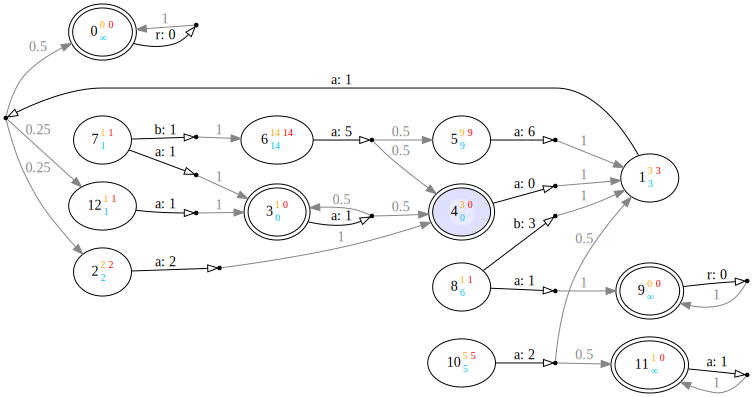

In [5]:
m.show("M")

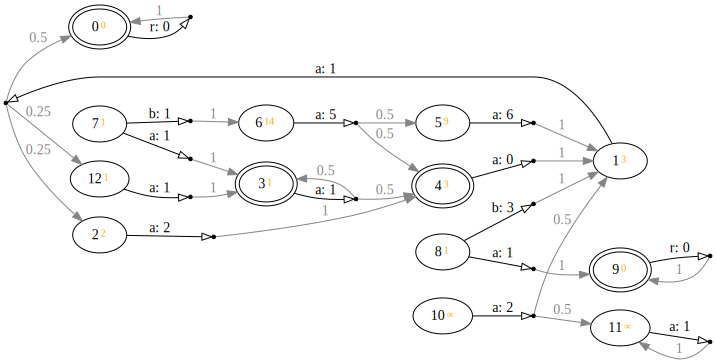

In [6]:
m.unset_reload(11)
m.show("M")

In [7]:
print(MI.get_values())
MI2 = minInitCons(m)
MI2.get_values()

[0, 3, 2, 1, 3, 9, 14, 1, 1, 0, 5, 1, 1]


[0, 3, 2, 1, 3, 9, 14, 1, 1, 0, inf, inf, 1]

## MinInitCons with capacity
We expect no change with capacity 14 as it is the highest minInitCons reached in the example. For `capacity=13`, however, there should be `∞` on state 6.

[0, 3, 2, 1, 3, 9, 14, 1, 1, 0, inf, inf, 1]


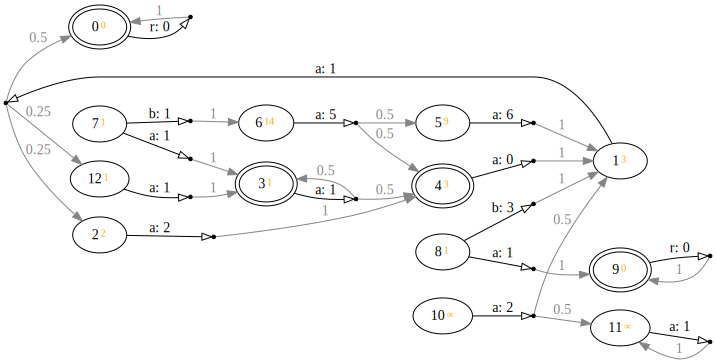

In [8]:
m.get_minInitCons(capacity=14)
print(m.minInitCons.values)
m

[0, 3, 2, 1, 3, 9, inf, 1, 1, 0, inf, inf, 1]


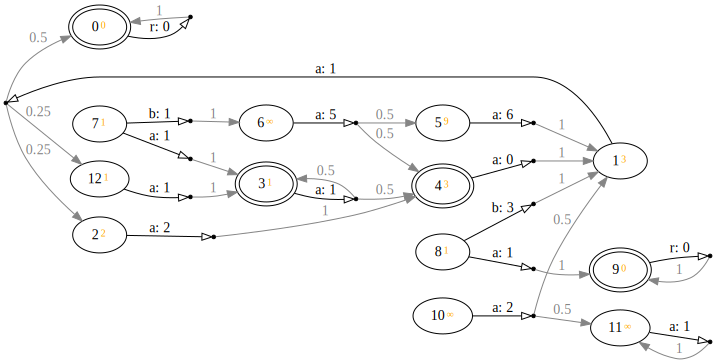

In [9]:
m.get_minInitCons(capacity=13)
print(m.minInitCons.values)
m

# SafeReloads
Safe reloads compute $\mathrm{minInitCons}$ such that only reload states $r$ with $\mathrm{minInitCons}(r) <= \mathsf{capacity}$ are considered as true reload states. Note that you should always specify `capacity` (either explicitly or when creating `minInitCons` object) as it makes no sense with `capacity = 0`. We visualize them with a red color. 

In [10]:
# Change the consumption on the action of st. 4
a = next(m.actions_for_state(3))
a.cons = 9

m.get_safeReloads(8)

[0, inf, inf, inf, inf, inf, inf, inf, 1, 0, inf, inf, inf]

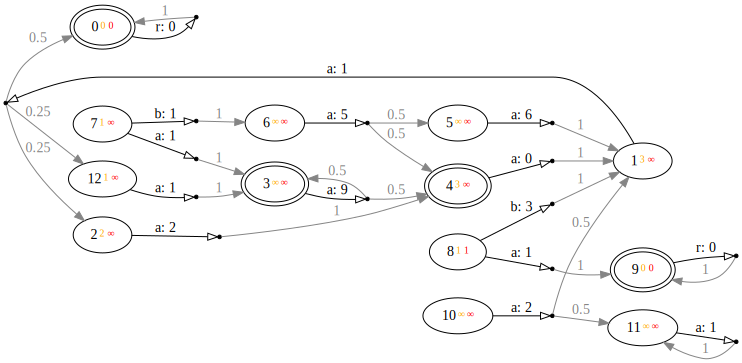

In [11]:
m.show("S")

[0, 3, 2, 0, 0, 9, 14, 1, 1, 0, inf, inf, 1]


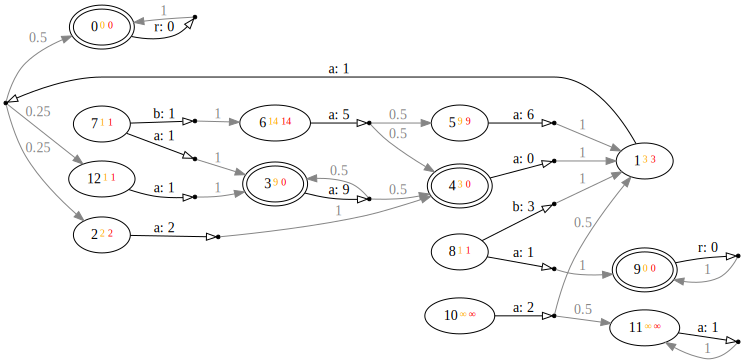

In [12]:
print(m.get_safeReloads(14))
m.show()